# **Importing Libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install datasets
!pip install torch-geometric
!pip install contractions
!pip install optuna

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import numpy as np
import re
import contractions
import numpy as np
import spacy
from spacy import displacy
import torch
from transformers import BertModel, BertTokenizer
from transformers import BertForSequenceClassification
from transformers import pipeline
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight
from torch_geometric.loader import DataLoader
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from datasets import load_dataset
import json
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import optuna

In [4]:
nlp = spacy.load("en_core_web_sm")

In [5]:
bert_model_finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3, output_hidden_states=True)
tokenizer_finbert = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

# **1. Data Pre-processing**

## 1.1. fiqa-2018-task1 dataset

In [6]:
with open('/content/drive/MyDrive/1/data/fiqa-2018-task1/task1_headline_ABSA.json', 'r') as file:
    data = json.load(file)

rows = []
for key, value in data.items():
    sentence = value["sentence"]
    sentiment_score = float(value["info"][0]["sentiment_score"])
    rows.append({"sentence": sentence, "sentiment_score": sentiment_score})

fiqa_2018_task1_headline_dataset = pd.DataFrame(rows)
fiqa_2018_task1_headline_dataset

,sentence,sentiment_score
0,Royal Mail chairman Donald Brydon set to step ...,-0.374
1,Stakes High for AstraZeneca Heart Drug Facing ...,-0.240
2,UPDATE 1-Dairy Crest loses a third of Morrison...,-0.161
3,Insight hires Aviva's David Hillier for multi-...,0.137
4,Primark racks up a happy Christmas after stron...,0.704
...,...,...
433,"Aviva, M&G suspend property funds as investors...",-0.807
434,"UK housing market steadies after Brexit dip, P...",0.339
435,BRIEF-Aviva aims to increase dividend pay-out ...,0.439
436,Builder Persimmon hails 6% rise in house sales,0.435


In [7]:
def add_sentiment_column(df):
    conditions = [
        df['sentiment_score'] < 0,
        df['sentiment_score'] > 0,
        df['sentiment_score'] == 0
    ]
    choices = ['negative', 'positive', 'neutral']
    df['sentiment'] = np.select(conditions, choices, default='neutral')
    return df

In [8]:
fiqa_2018_task1_headline_dataset = add_sentiment_column(fiqa_2018_task1_headline_dataset)

In [9]:
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
fiqa_2018_task1_headline_dataset['sentiment_mapping'] = fiqa_2018_task1_headline_dataset['sentiment'].map(sentiment_mapping)

In [10]:
fiqa_2018_task1_headline_dataset

,sentence,sentiment_score,sentiment,sentiment_mapping
0,Royal Mail chairman Donald Brydon set to step ...,-0.374,negative,0
1,Stakes High for AstraZeneca Heart Drug Facing ...,-0.240,negative,0
2,UPDATE 1-Dairy Crest loses a third of Morrison...,-0.161,negative,0
3,Insight hires Aviva's David Hillier for multi-...,0.137,positive,2
4,Primark racks up a happy Christmas after stron...,0.704,positive,2
...,...,...,...,...
433,"Aviva, M&G suspend property funds as investors...",-0.807,negative,0
434,"UK housing market steadies after Brexit dip, P...",0.339,positive,2
435,BRIEF-Aviva aims to increase dividend pay-out ...,0.439,positive,2
436,Builder Persimmon hails 6% rise in house sales,0.435,positive,2


In [11]:
fiqa_2018_task1_headline_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438 entries, 0 to 437
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sentence           438 non-null    object 
 1   sentiment_score    438 non-null    float64
 2   sentiment          438 non-null    object 
 3   sentiment_mapping  438 non-null    int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 13.8+ KB


In [12]:
fiqa_2018_task1_headline_dataset['sentiment_score'].describe()

count    438.000000
mean       0.090114
std        0.384561
min       -0.938000
25%       -0.197500
50%        0.189000
75%        0.365750
max        0.975000
Name: sentiment_score, dtype: float64



---



In [13]:
with open('/content/drive/MyDrive/1/data/fiqa-2018-task1/task1_post_ABSA.json', 'r') as file:
    data = json.load(file)

rows = []
for key, value in data.items():
    sentence = value["sentence"]
    sentiment_score = float(value["info"][0]["sentiment_score"])
    rows.append({"sentence": sentence, "sentiment_score": sentiment_score})

fiqa_2018_task1_post_dataset = pd.DataFrame(rows)
fiqa_2018_task1_post_dataset

,sentence,sentiment_score
0,Slowly adding some $FIO here but gotta be care...,0.459
1,$TRX http://stks.co/1KkK Long setup. MACD cross.,0.438
2,I am not optimistic about $amzn both fundement...,-0.506
3,$GRPN might be selling off ahead of $P earning...,-0.202
4,$IACI http://stks.co/tJU Looks good on the wee...,0.379
...,...,...
670,Facebook $FB received a Buy rating from Wells ...,0.456
671,$TSLA Wish had my puts back but see if we can ...,-0.485
672,Citrix Systems Inc $CTXS Position Increased by...,0.529
673,Notable gainers among liquid option names this...,0.513


In [14]:
fiqa_2018_task1_post_dataset = add_sentiment_column(fiqa_2018_task1_post_dataset)

In [15]:
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
fiqa_2018_task1_post_dataset['sentiment_mapping'] = fiqa_2018_task1_post_dataset['sentiment'].map(sentiment_mapping)

In [16]:
fiqa_2018_task1_post_dataset

,sentence,sentiment_score,sentiment,sentiment_mapping
0,Slowly adding some $FIO here but gotta be care...,0.459,positive,2
1,$TRX http://stks.co/1KkK Long setup. MACD cross.,0.438,positive,2
2,I am not optimistic about $amzn both fundement...,-0.506,negative,0
3,$GRPN might be selling off ahead of $P earning...,-0.202,negative,0
4,$IACI http://stks.co/tJU Looks good on the wee...,0.379,positive,2
...,...,...,...,...
670,Facebook $FB received a Buy rating from Wells ...,0.456,positive,2
671,$TSLA Wish had my puts back but see if we can ...,-0.485,negative,0
672,Citrix Systems Inc $CTXS Position Increased by...,0.529,positive,2
673,Notable gainers among liquid option names this...,0.513,positive,2


In [17]:
fiqa_2018_task1_post_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675 entries, 0 to 674
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sentence           675 non-null    object 
 1   sentiment_score    675 non-null    float64
 2   sentiment          675 non-null    object 
 3   sentiment_mapping  675 non-null    int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 21.2+ KB


In [18]:
fiqa_2018_task1_post_dataset['sentiment_score'].describe()

count    675.000000
mean       0.143124
std        0.414214
min       -0.745000
25%       -0.301000
50%        0.318000
75%        0.476500
max        0.814000
Name: sentiment_score, dtype: float64

## 1.2. **SemEVAL2017 Task 5** dataset

In [19]:
with open('/content/drive/MyDrive/1/data/semeval-2017-task-5-subtask-2/Headline.json', 'r') as file:
    data = json.load(file)

rows = []
for d in data:
    sentence = d["title"]
    sentiment_score = float(d["sentiment"])
    rows.append({"sentence": sentence, "sentiment_score": sentiment_score})

SemEVAL2017_Task5_dataset = pd.DataFrame(rows)
SemEVAL2017_Task5_dataset

,sentence,sentiment_score
0,Morrisons book second consecutive quarter of s...,0.430
1,IMI posts drop in first-quarter organic revenu...,-0.344
2,Glencore to refinance its short-term debt earl...,0.340
3,EasyJet attracts more passengers in June but s...,0.259
4,Barclays 'bad bank' chief to step down,-0.231
...,...,...
1137,"FDA panel backs Glaxo asthma drug for adults, ...",0.305
1138,Barclays set to name former JPMorgan banker St...,0.000
1139,Kingfisher share price slides on cost to imple...,-0.786
1140,"CompaniesTravis Perkins lifts dividend, earnin...",0.494


In [20]:
SemEVAL2017_Task5_dataset = add_sentiment_column(SemEVAL2017_Task5_dataset)

In [21]:
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
SemEVAL2017_Task5_dataset['sentiment_mapping'] = SemEVAL2017_Task5_dataset['sentiment'].map(sentiment_mapping)

In [22]:
SemEVAL2017_Task5_dataset

,sentence,sentiment_score,sentiment,sentiment_mapping
0,Morrisons book second consecutive quarter of s...,0.430,positive,2
1,IMI posts drop in first-quarter organic revenu...,-0.344,negative,0
2,Glencore to refinance its short-term debt earl...,0.340,positive,2
3,EasyJet attracts more passengers in June but s...,0.259,positive,2
4,Barclays 'bad bank' chief to step down,-0.231,negative,0
...,...,...,...,...
1137,"FDA panel backs Glaxo asthma drug for adults, ...",0.305,positive,2
1138,Barclays set to name former JPMorgan banker St...,0.000,neutral,1
1139,Kingfisher share price slides on cost to imple...,-0.786,negative,0
1140,"CompaniesTravis Perkins lifts dividend, earnin...",0.494,positive,2


In [23]:
SemEVAL2017_Task5_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1142 entries, 0 to 1141
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sentence           1142 non-null   object 
 1   sentiment_score    1142 non-null   float64
 2   sentiment          1142 non-null   object 
 3   sentiment_mapping  1142 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 35.8+ KB


In [24]:
SemEVAL2017_Task5_dataset['sentiment_score'].describe()

count    1142.000000
mean        0.031049
std         0.393775
min        -0.989000
25%        -0.281750
50%         0.107000
75%         0.323000
max         0.989000
Name: sentiment_score, dtype: float64

## 1.3. financial phrasebank dataset

In [25]:
dataset_fp = load_dataset("financial_phrasebank", 'sentences_50agree')
df_fp = pd.DataFrame(dataset_fp['train'])

Generating train split:   0%|          | 0/4846 [00:00<?, ? examples/s]

In [26]:
# sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df_fp

,sentence,label
0,"According to Gran , the company has no plans t...",1
1,Technopolis plans to develop in stages an area...,1
2,The international electronic industry company ...,0
3,With the new production plant the company woul...,2
4,According to the company 's updated strategy f...,2
...,...,...
4841,LONDON MarketWatch -- Share prices ended lower...,0
4842,Rinkuskiai 's beer sales fell by 6.5 per cent ...,1
4843,Operating profit fell to EUR 35.4 mn from EUR ...,0
4844,Net sales of the Paper segment decreased to EU...,0




## 1.4. Combined dataset



In [27]:
df12 = pd.concat([fiqa_2018_task1_headline_dataset, fiqa_2018_task1_post_dataset, SemEVAL2017_Task5_dataset], axis=0, ignore_index=True)

In [28]:
df12.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2255 entries, 0 to 2254
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sentence           2255 non-null   object 
 1   sentiment_score    2255 non-null   float64
 2   sentiment          2255 non-null   object 
 3   sentiment_mapping  2255 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 70.6+ KB


In [29]:
df12 = df12.rename(columns={"sentiment_mapping": "label"})

In [30]:
df = pd.concat([df12[['sentence', 'label']], df_fp], axis=0, ignore_index=True)

In [31]:
df

,sentence,label
0,Royal Mail chairman Donald Brydon set to step ...,0
1,Stakes High for AstraZeneca Heart Drug Facing ...,0
2,UPDATE 1-Dairy Crest loses a third of Morrison...,0
3,Insight hires Aviva's David Hillier for multi-...,2
4,Primark racks up a happy Christmas after stron...,2
...,...,...
7096,LONDON MarketWatch -- Share prices ended lower...,0
7097,Rinkuskiai 's beer sales fell by 6.5 per cent ...,1
7098,Operating profit fell to EUR 35.4 mn from EUR ...,0
7099,Net sales of the Paper segment decreased to EU...,0


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7101 entries, 0 to 7100
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  7101 non-null   object
 1   label     7101 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 111.1+ KB




---



In [33]:
def process_sentence(sentence):
    # Expand contractions
    sentence = contractions.fix(sentence)

    # Remove URLs
    sentence = re.sub(r'http\S+|www\S+|https\S+', '', sentence, flags=re.MULTILINE)

    # Remove currency symbols
    sentence = re.sub(r'\$', 'dollar ', sentence)

    # Remove usernames
    sentence = re.sub(r'@\w+', '', sentence)

    # Remove punctuation
    sentence = re.sub(r'[^\w\s]', '', sentence)

    # Handle special characters
    sentence = re.sub(r'[^A-Za-z0-9\s]', '', sentence)

    return sentence

In [34]:
df['sentence'] = df['sentence'].apply(process_sentence)

In [35]:
df

,sentence,label
0,Royal Mail chairman Donald Brydon set to step ...,0
1,Stakes High for AstraZeneca Heart Drug Facing ...,0
2,UPDATE 1Dairy Crest loses a third of Morrisons...,0
3,Insight hires Avivas David Hillier for multias...,2
4,Primark racks up a happy Christmas after stron...,2
...,...,...
7096,LONDON MarketWatch Share prices ended lower i...,0
7097,Rinkuskiai s beer sales fell by 65 per cent to...,1
7098,Operating profit fell to EUR 354 mn from EUR 6...,0
7099,Net sales of the Paper segment decreased to EU...,0


# **2. Exploratory Data Analysis**

In [36]:
def HistogramPlotter(df, title):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['sentiment_score'], bins=20, kde=True)
    plt.title(f"Sentiment Score Distribution for {title}")
    plt.show()

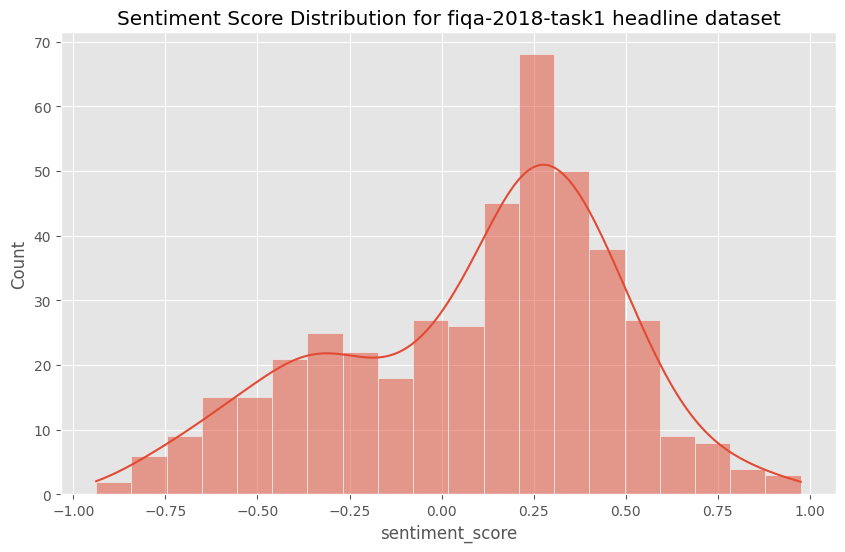

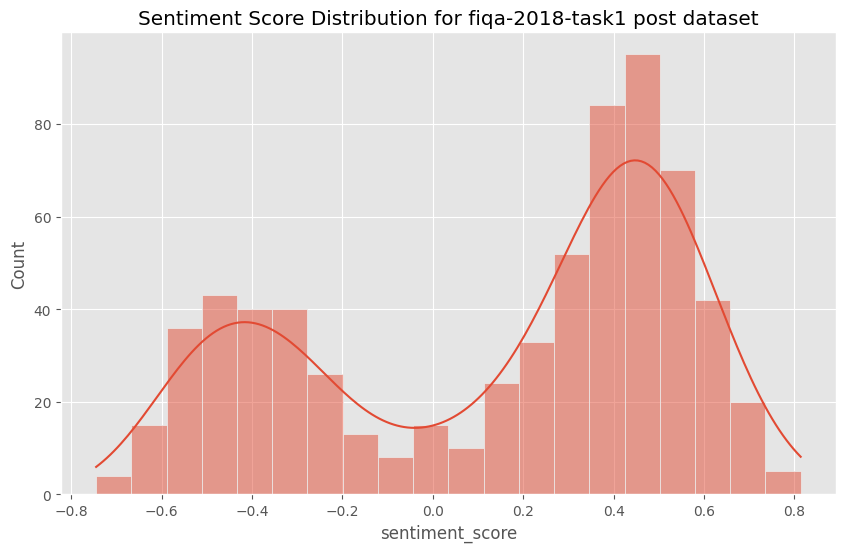

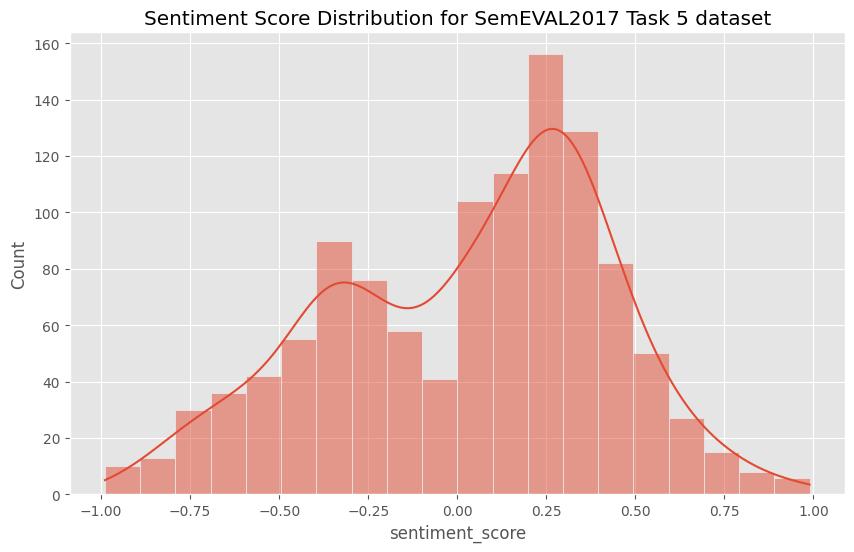

In [37]:
HistogramPlotter(fiqa_2018_task1_headline_dataset, 'fiqa-2018-task1 headline dataset')
HistogramPlotter(fiqa_2018_task1_post_dataset, 'fiqa-2018-task1 post dataset')
HistogramPlotter(SemEVAL2017_Task5_dataset, 'SemEVAL2017 Task 5 dataset')

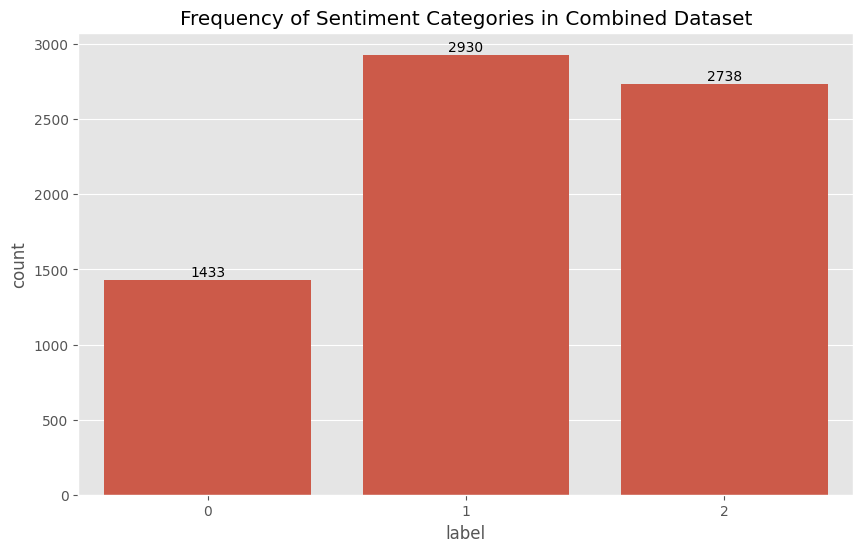

In [38]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='label', data=df)
plt.title("Frequency of Sentiment Categories in Combined Dataset")
ax.bar_label(ax.containers[0])
plt.show()

# **3. FinBERT Context Encoding**

In [39]:
# Load pre-trained BERT model and tokenizer
bert_model = bert_model_finbert
tokenizer = tokenizer_finbert

In [40]:
# Find the longest sentence in terms of tokens
max_tokens = 0

for index, row in df.iterrows():
    sentence = row['sentence']
    tokens = tokenizer.tokenize(sentence)
    max_tokens = max(max_tokens, len(tokens))

print(max_tokens)

93


In [41]:
# Move the BERT model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

embeddings_list = []

for index, row in tqdm(df.iterrows(), total=len(df), desc="Encoding Sentences"):
    sentence = row['sentence']
    tokens = tokenizer(sentence, padding='max_length', max_length=max_tokens, truncation=True, return_tensors='pt')

    # Move tokens to GPU
    tokens = {key: value.to(device) for key, value in tokens.items()}

    # Pass the tokenized sentence to BERT
    with torch.inference_mode():
        output = bert_model(**tokens)

    # Get the embeddings for each token (ignoring special tokens)
    hidden_states = output.hidden_states
    embeddings = hidden_states[-1][:, 1:-1, :]
    embeddings_list.append(embeddings)

# Now, all embeddings will have the same shape (1, max_tokens-2, 768).

Encoding Sentences: 100%|██████████| 7101/7101 [01:36<00:00, 73.97it/s]


In [42]:
embeddings_list[0].shape

torch.Size([1, 91, 768])

In [43]:
reshaped_embeddings_list = [tensor.view(91, 768) for tensor in embeddings_list]
print(reshaped_embeddings_list[0].shape)

torch.Size([91, 768])


# **4. Dependency Graph Construction**

In [44]:
# Process the text with spaCy
doc = nlp(df['sentence'][0])

# Render the dependency graph using displacy
displacy.render(doc, style="dep", jupyter=True)

In [45]:
def build_directed_dependency_graph(sentence):
    # Parse the sentence using spaCy
    doc = nlp(sentence)

    # Initialize an adjacency matrix as a list of lists
    adjacency_matrix = [[0.0] * len(doc) for _ in range(len(doc))]

    # Fill the adjacency matrix based on the directed dependency tree
    for token in doc:
        for child in token.children:
            adjacency_matrix[token.i][child.i] = 1.0  # Edge from parent to child

    # Convert the adjacency matrix to a PyTorch tensor
    adjacency_matrix = torch.tensor(adjacency_matrix, dtype=torch.long)

    return adjacency_matrix

In [46]:
adjacency_matrices_list = []
padded_adjacency_matrices_list = []
max_matrix_size = max_tokens - 2

for index, row in tqdm(df.iterrows(), total=len(df), desc="Building Adjacency Matrices"):
    sentence = row['sentence']
    adjacency_matrix = build_directed_dependency_graph(sentence)

    num_nodes = adjacency_matrix.shape[0]

    if num_nodes < max_matrix_size:
        padding = max_matrix_size - num_nodes
        padded_matrix = np.pad(adjacency_matrix, ((0, padding), (0, padding)), 'constant')

    padded_matrix = torch.tensor(padded_matrix, dtype=torch.long)

    adjacency_matrices_list.append(adjacency_matrix)
    padded_adjacency_matrices_list.append(padded_matrix)

Building Adjacency Matrices: 100%|██████████| 7101/7101 [01:18<00:00, 90.88it/s]


# **5. Models with training, testing and Hyperparameter Tuning with Results**

In [47]:
data_list = []
labels = torch.tensor(df['label'].tolist(), dtype=torch.long)

for i in tqdm(range(len(padded_adjacency_matrices_list)), total=len(padded_adjacency_matrices_list), desc="Building a list of Data Objects"):
    adjacency_matrix = padded_adjacency_matrices_list[i]
    node_features = reshaped_embeddings_list[i]
    label = labels[i]

    # Convert adjacency matrix to a COO format
    edge_index = torch.tensor(adjacency_matrix.nonzero(), dtype=torch.long).t().contiguous()

    data = Data(x=node_features, edge_index=edge_index, y=label)

    data_list.append(data)

Building a list of Data Objects: 100%|██████████| 7101/7101 [00:01<00:00, 5838.01it/s]


In [48]:
len(data_list)

7101

In [49]:
data_list[0]

Data(x=[91, 768], edge_index=[2, 8], y=0)

In [50]:
# 80% of the data for training and 20% for testing
train_size = int(0.8 * len(data_list))
test_size = len(data_list) - train_size

# Split the dataset into train and test sets
train_dataset, test_dataset = random_split(data_list, [train_size, test_size])

In [51]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [90]:
class_weight = compute_class_weight(class_weight="balanced", classes=np.unique(labels.numpy()), y=labels.numpy())
torch.tensor(class_weight, dtype=torch.float32)

tensor([1.6518, 0.8078, 0.8645])

In [52]:
for data in train_loader:
  print(data)
  break

DataBatch(x=[5824, 768], edge_index=[2, 1065], y=[64], batch=[5824], ptr=[65])


In [53]:
def plot_confusion_matrix(actual_values, predicted_values, ticklabels):
  conf_matrix = confusion_matrix(actual_values, predicted_values)
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='crest', xticklabels=ticklabels, yticklabels=ticklabels)
  plt.title("Confusion Matrix")
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

def get_classification_report(actual_values, predicted_values, target_names):
  classification_report_result = classification_report(actual_values, predicted_values, target_names=target_names, digits=4)
  print("\n\nClassification Report:\n\n", classification_report_result)

## GCNConv layers

In [ ]:
# Define the PyTorch model
class GCN_GCNConv(torch.nn.Module):
    def __init__(self, input_dim, hidden_channels, num_classes):
        super(GCN_GCNConv, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        # Obtaining the node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # Readout layer
        x = global_mean_pool(x, batch)

        # Applying a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

# Define the objective function for Optuna
def objective(trial):

    # set GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define hyperparameters to be optimized
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    hidden_size = trial.suggest_int('hidden_size', 32, 512, log=True)
    batch_size = trial.suggest_int('batch_size', 32, 64, log=True)
    num_epochs = trial.suggest_int('num_epochs', 5, 10, log=True)

    # Set up the PyTorch model with the suggested hyperparameters
    model = GCN_GCNConv(input_dim=768, hidden_channels=hidden_size, num_classes=3).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()

    # Move the model to GPU if available
    model.to(device)

    # Set up the data loaders (train_loader, test_loader)
    batch_size = batch_size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Train the model using the training loop
    train_losses = []  # to store training losses for each epoch
    num_epochs = num_epochs
    for epoch in range(num_epochs):
      model.train()
      epoch_loss = 0.0
      for data in train_loader:
        data = data.to(device)  # Move data to GPU
        model_out = model(data.x, data.edge_index, data.batch)
        model_loss = loss_fn(model_out, data.y)

        optimizer.zero_grad()
        model_loss.backward()
        optimizer.step()

        epoch_loss += model_loss.item()

      # Calculate and store average training loss for the epoch
      avg_epoch_loss = epoch_loss / len(train_loader.dataset)
      train_losses.append(avg_epoch_loss)

    # Evaluate the model
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    with torch.inference_mode():
      for data in test_loader:
        data = data.to(device)  # Move data to GPU
        model_out = model(data.x, data.edge_index, data.batch)
        pred = model_out.argmax(dim=1)
        correct = correct + int((pred == data.y).sum())

        pred_cpu = pred.cpu().numpy()
        all_preds.extend(pred_cpu)
        data_y_cpu = data.y.cpu().numpy()
        all_labels.extend(data_y_cpu)

    accuracy = correct / len(test_loader.dataset)

    # Additional Evaluation Metrics and Visualizations
    num_classes = 3
    class_labels = [f'Class {i}' for i in range(num_classes)]

    print()
    print("\n=======================================================================================================================================\n")
    # Plot training loss over epochs
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    print("\n----------------------------------------------------------------------------------------\n")
    get_classification_report(all_labels, all_preds, class_labels)
    print("\n----------------------------------------------------------------------------------------\n")
    plot_confusion_matrix(all_labels, all_preds, class_labels)
    print("\n=======================================================================================================================================\n")
    print()

    # Report the metric to Optuna (maximize accuracy)
    return accuracy

[I 2024-01-09 11:38:40,318] A new study created in memory with name: no-name-467f5900-8792-4dc3-8a17-d948fb733446


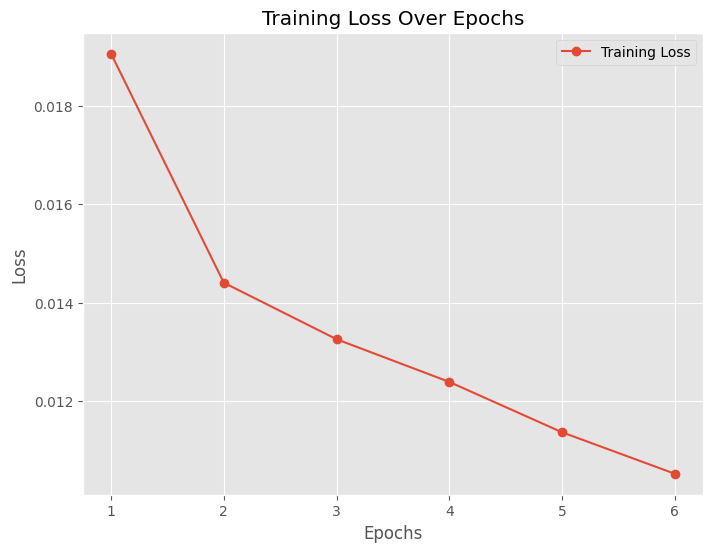


----------------------------------------------------------------------------------------



Classification Report:

               precision    recall  f1-score   support

     Class 0     0.8120    0.7302    0.7689       278
     Class 1     0.8460    0.8894    0.8672       624
     Class 2     0.7942    0.7881    0.7911       519

    accuracy                         0.8213      1421
   macro avg     0.8174    0.8026    0.8091      1421
weighted avg     0.8204    0.8213    0.8202      1421


----------------------------------------------------------------------------------------



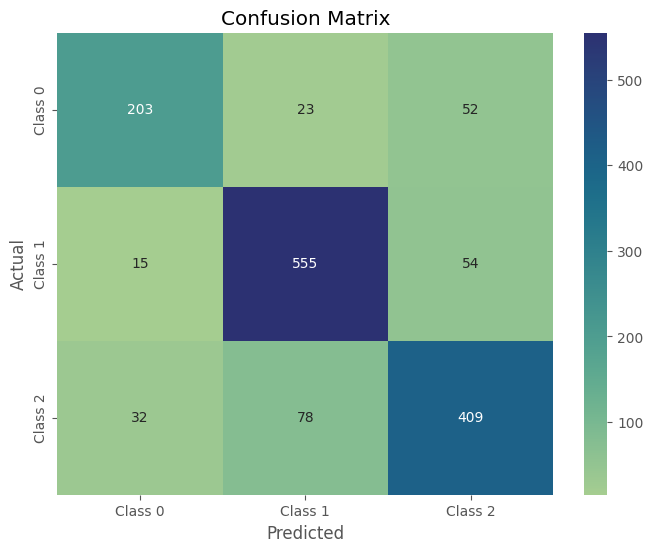

[I 2024-01-09 11:38:48,689] Trial 0 finished with value: 0.8212526389866291 and parameters: {'learning_rate': 0.0005442417656253356, 'hidden_size': 50, 'batch_size': 35, 'num_epochs': 6}. Best is trial 0 with value: 0.8212526389866291.



----------------------------------------------------------------------------------------









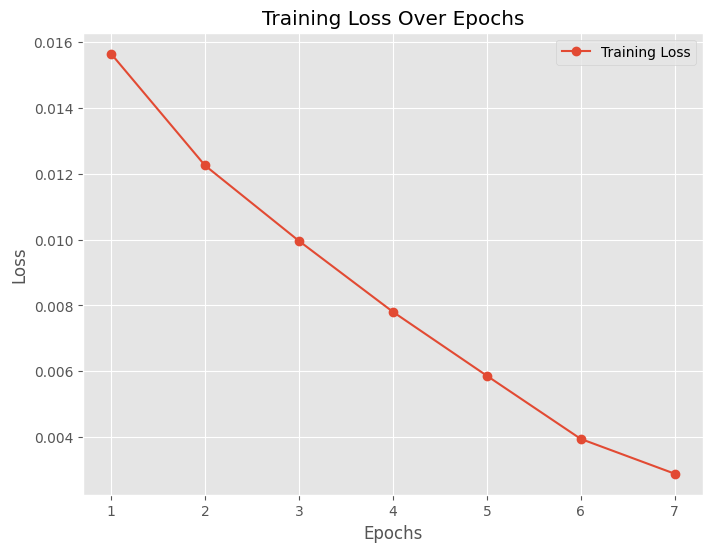


----------------------------------------------------------------------------------------



Classification Report:

               precision    recall  f1-score   support

     Class 0     0.7703    0.8201    0.7944       278
     Class 1     0.9078    0.8365    0.8707       624
     Class 2     0.7891    0.8362    0.8120       519

    accuracy                         0.8332      1421
   macro avg     0.8224    0.8310    0.8257      1421
weighted avg     0.8375    0.8332    0.8343      1421


----------------------------------------------------------------------------------------



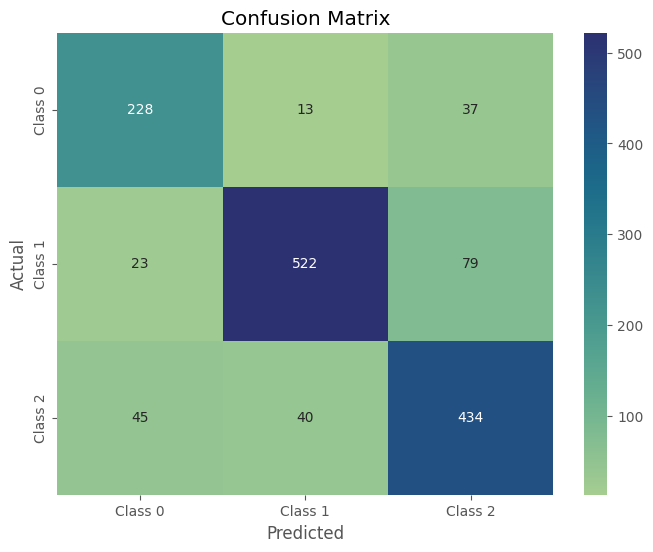

[I 2024-01-09 11:39:00,057] Trial 1 finished with value: 0.8332160450387052 and parameters: {'learning_rate': 0.0007661868183492439, 'hidden_size': 467, 'batch_size': 37, 'num_epochs': 7}. Best is trial 1 with value: 0.8332160450387052.



----------------------------------------------------------------------------------------









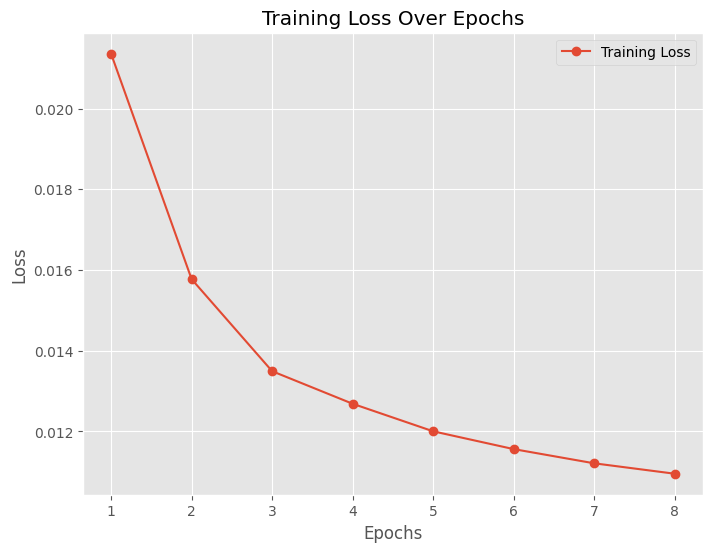


----------------------------------------------------------------------------------------



Classification Report:

               precision    recall  f1-score   support

     Class 0     0.7726    0.7698    0.7712       278
     Class 1     0.8251    0.8542    0.8394       624
     Class 2     0.7731    0.7418    0.7571       519

    accuracy                         0.7966      1421
   macro avg     0.7902    0.7886    0.7892      1421
weighted avg     0.7958    0.7966    0.7960      1421


----------------------------------------------------------------------------------------



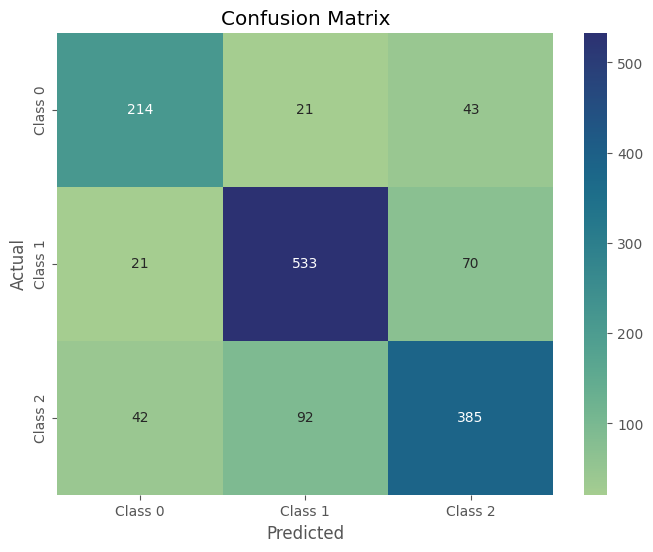

[I 2024-01-09 11:39:08,855] Trial 2 finished with value: 0.796622097114708 and parameters: {'learning_rate': 4.3234762266976224e-05, 'hidden_size': 131, 'batch_size': 45, 'num_epochs': 8}. Best is trial 1 with value: 0.8332160450387052.



----------------------------------------------------------------------------------------









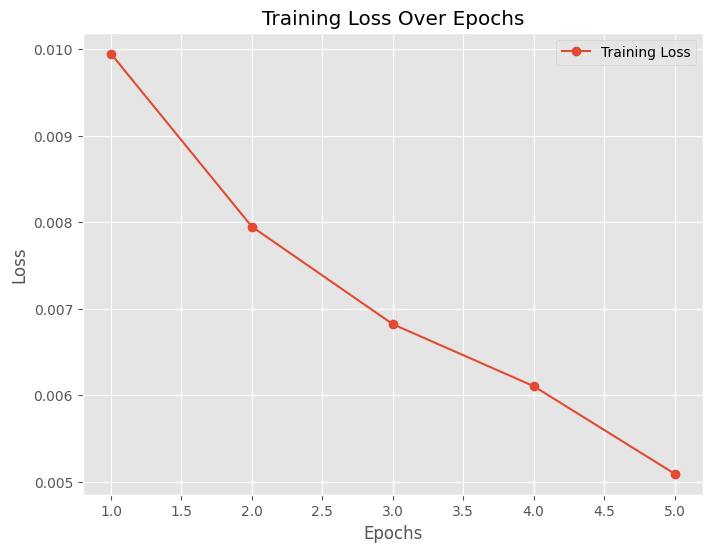


----------------------------------------------------------------------------------------



Classification Report:

               precision    recall  f1-score   support

     Class 0     0.7566    0.8273    0.7904       278
     Class 1     0.8341    0.9103    0.8705       624
     Class 2     0.8463    0.7110    0.7728       519

    accuracy                         0.8213      1421
   macro avg     0.8123    0.8162    0.8112      1421
weighted avg     0.8234    0.8213    0.8191      1421


----------------------------------------------------------------------------------------



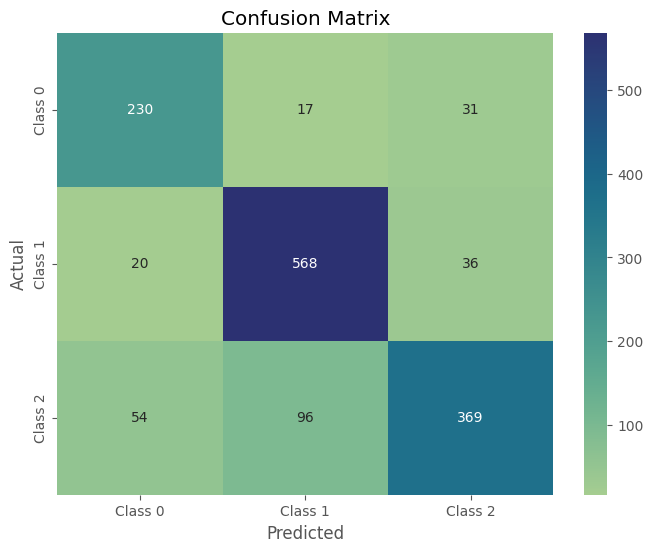

[I 2024-01-09 11:39:13,228] Trial 3 finished with value: 0.8212526389866291 and parameters: {'learning_rate': 0.0018223125797335606, 'hidden_size': 103, 'batch_size': 59, 'num_epochs': 5}. Best is trial 1 with value: 0.8332160450387052.



----------------------------------------------------------------------------------------









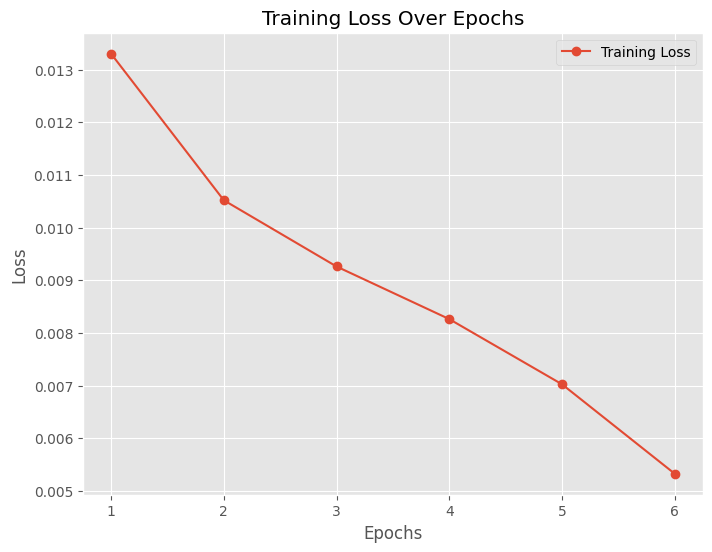


----------------------------------------------------------------------------------------



Classification Report:

               precision    recall  f1-score   support

     Class 0     0.7582    0.7446    0.7514       278
     Class 1     0.8773    0.8590    0.8680       624
     Class 2     0.7784    0.8054    0.7917       519

    accuracy                         0.8170      1421
   macro avg     0.8046    0.8030    0.8037      1421
weighted avg     0.8179    0.8170    0.8173      1421


----------------------------------------------------------------------------------------



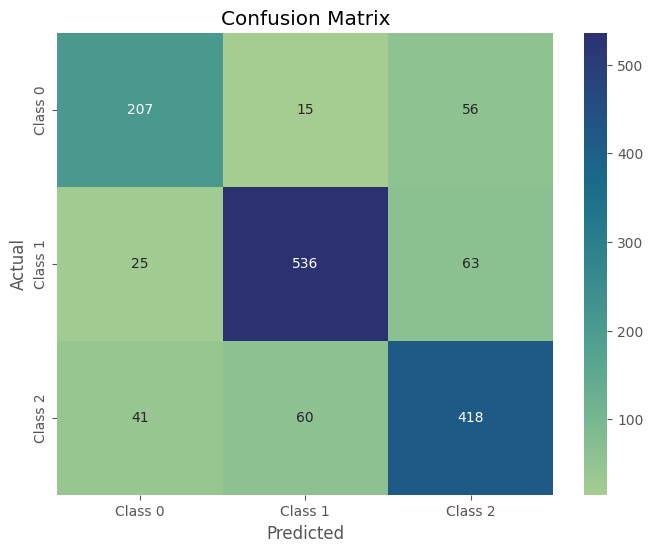

[I 2024-01-09 11:39:20,567] Trial 4 finished with value: 0.817030260380014 and parameters: {'learning_rate': 0.0005873905888301064, 'hidden_size': 230, 'batch_size': 44, 'num_epochs': 6}. Best is trial 1 with value: 0.8332160450387052.



----------------------------------------------------------------------------------------









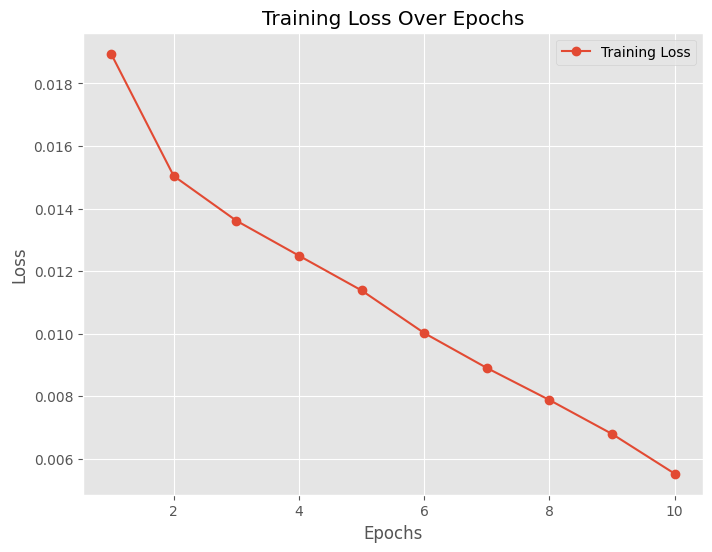


----------------------------------------------------------------------------------------



Classification Report:

               precision    recall  f1-score   support

     Class 0     0.7372    0.7770    0.7566       278
     Class 1     0.9009    0.8301    0.8641       624
     Class 2     0.7703    0.8208    0.7948       519

    accuracy                         0.8163      1421
   macro avg     0.8028    0.8093    0.8051      1421
weighted avg     0.8212    0.8163    0.8177      1421


----------------------------------------------------------------------------------------



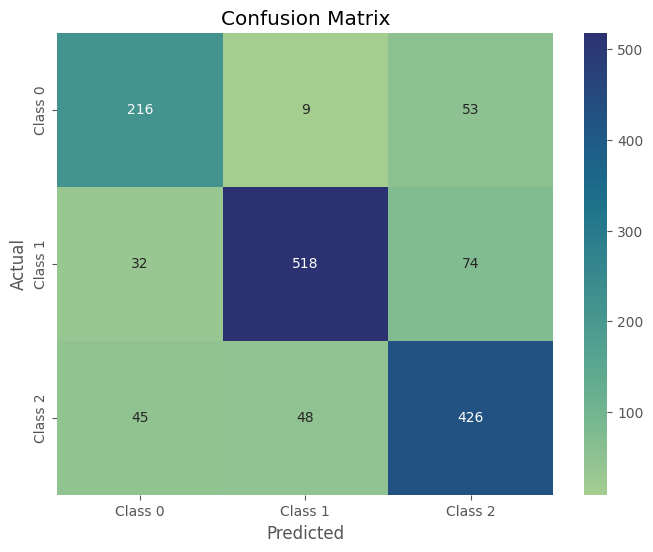

[I 2024-01-09 11:39:33,211] Trial 5 finished with value: 0.8163265306122449 and parameters: {'learning_rate': 0.0003519565003480491, 'hidden_size': 131, 'batch_size': 33, 'num_epochs': 10}. Best is trial 1 with value: 0.8332160450387052.



----------------------------------------------------------------------------------------









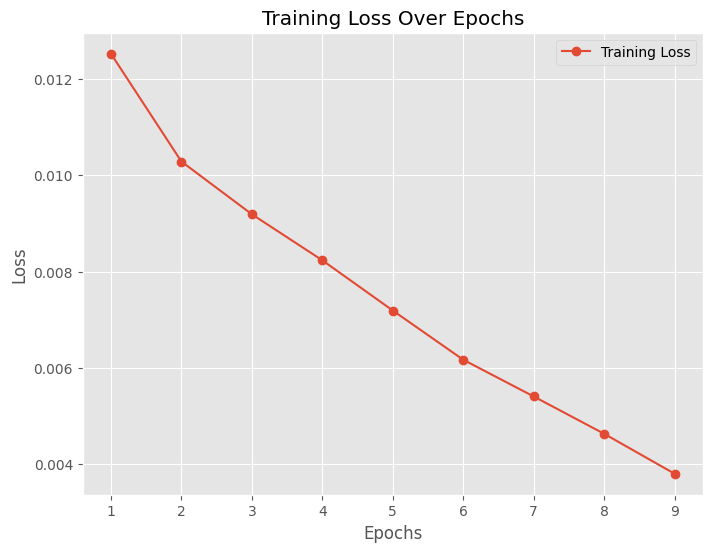


----------------------------------------------------------------------------------------



Classification Report:

               precision    recall  f1-score   support

     Class 0     0.7256    0.8561    0.7855       278
     Class 1     0.9024    0.8446    0.8725       624
     Class 2     0.8055    0.7900    0.7977       519

    accuracy                         0.8269      1421
   macro avg     0.8112    0.8302    0.8186      1421
weighted avg     0.8324    0.8269    0.8282      1421


----------------------------------------------------------------------------------------



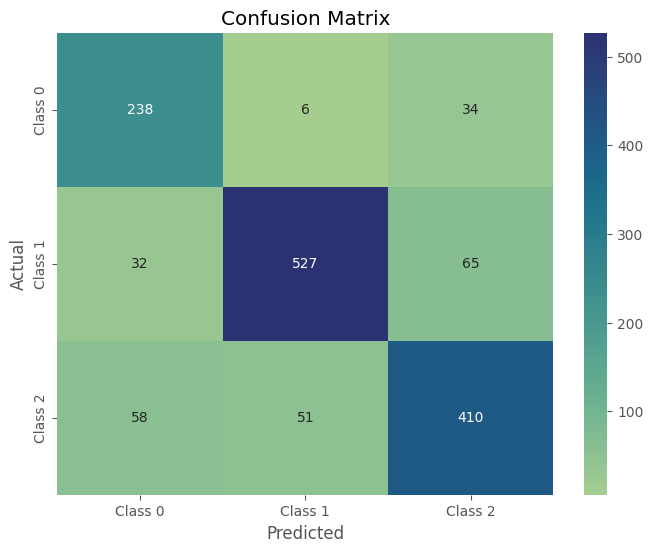

[I 2024-01-09 11:39:41,657] Trial 6 finished with value: 0.8268824771287826 and parameters: {'learning_rate': 0.002908392471245992, 'hidden_size': 48, 'batch_size': 48, 'num_epochs': 9}. Best is trial 1 with value: 0.8332160450387052.



----------------------------------------------------------------------------------------









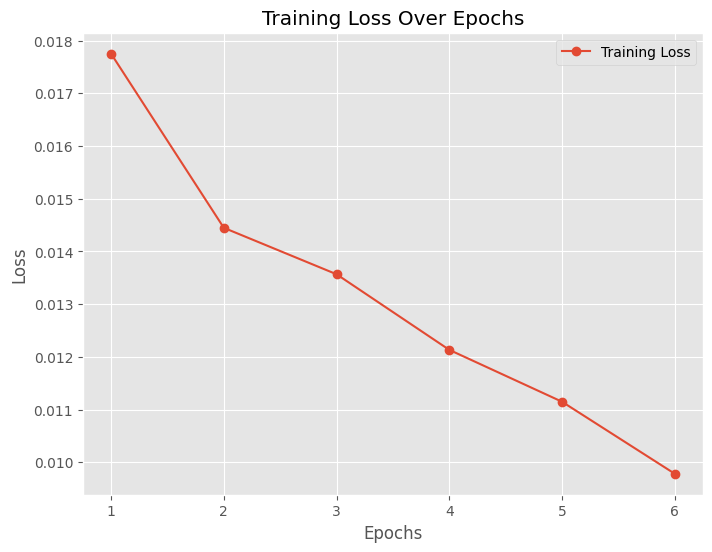


----------------------------------------------------------------------------------------



Classification Report:

               precision    recall  f1-score   support

     Class 0     0.7224    0.7770    0.7487       278
     Class 1     0.8389    0.8926    0.8649       624
     Class 2     0.8166    0.7206    0.7656       519

    accuracy                         0.8072      1421
   macro avg     0.7926    0.7967    0.7931      1421
weighted avg     0.8079    0.8072    0.8059      1421


----------------------------------------------------------------------------------------



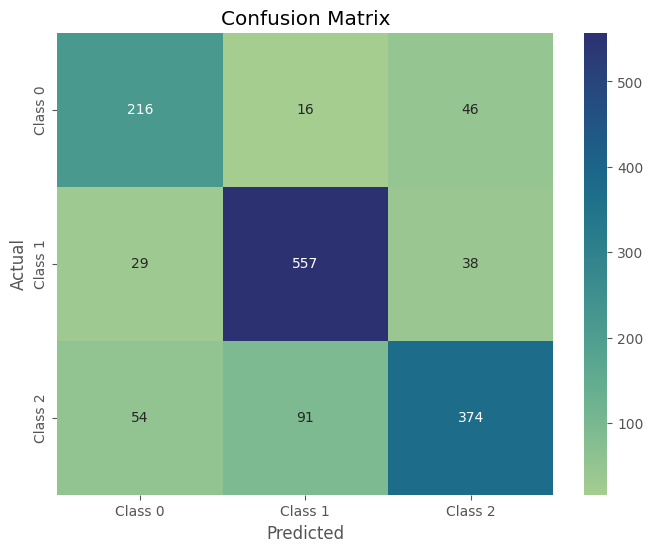

[I 2024-01-09 11:39:53,283] Trial 7 finished with value: 0.8071780436312456 and parameters: {'learning_rate': 0.006739160003523756, 'hidden_size': 62, 'batch_size': 34, 'num_epochs': 6}. Best is trial 1 with value: 0.8332160450387052.



----------------------------------------------------------------------------------------









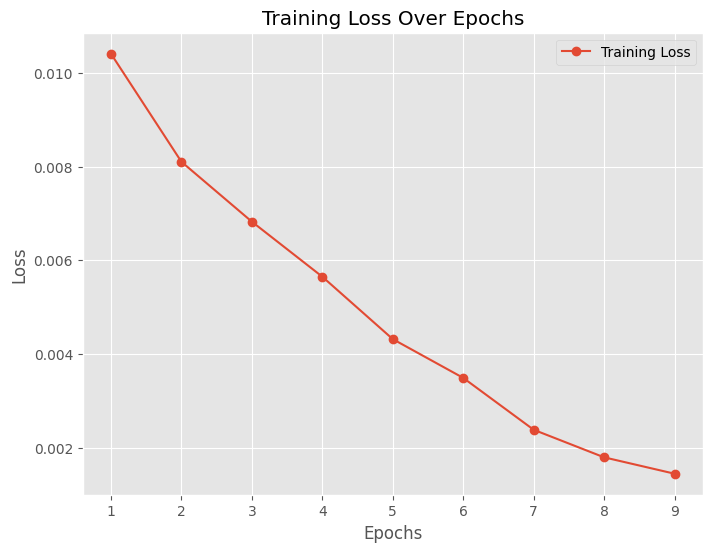


----------------------------------------------------------------------------------------



Classification Report:

               precision    recall  f1-score   support

     Class 0     0.7630    0.7410    0.7518       278
     Class 1     0.8076    0.9151    0.8580       624
     Class 2     0.8266    0.7071    0.7622       519

    accuracy                         0.8051      1421
   macro avg     0.7991    0.7877    0.7907      1421
weighted avg     0.8058    0.8051    0.8022      1421


----------------------------------------------------------------------------------------



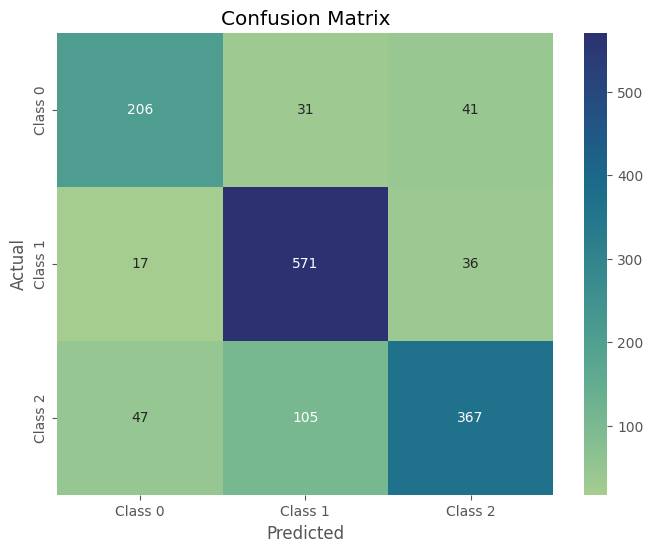

[I 2024-01-09 11:40:07,418] Trial 8 finished with value: 0.8050668543279381 and parameters: {'learning_rate': 0.001664011643994358, 'hidden_size': 292, 'batch_size': 56, 'num_epochs': 9}. Best is trial 1 with value: 0.8332160450387052.



----------------------------------------------------------------------------------------









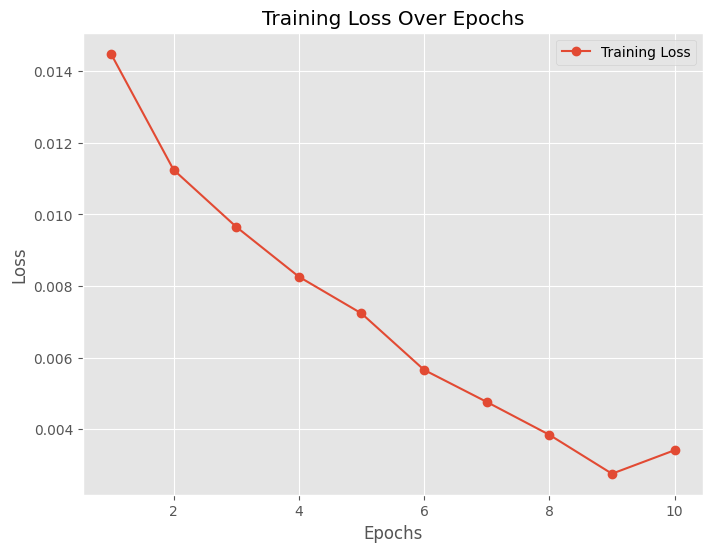


----------------------------------------------------------------------------------------



Classification Report:

               precision    recall  f1-score   support

     Class 0     0.7878    0.7878    0.7878       278
     Class 1     0.8734    0.8734    0.8734       624
     Class 2     0.8073    0.8073    0.8073       519

    accuracy                         0.8325      1421
   macro avg     0.8228    0.8228    0.8228      1421
weighted avg     0.8325    0.8325    0.8325      1421


----------------------------------------------------------------------------------------



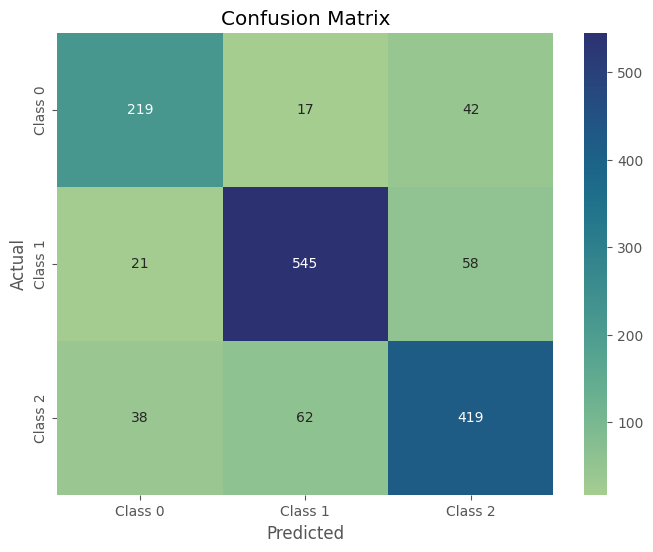

[I 2024-01-09 11:40:19,130] Trial 9 finished with value: 0.8325123152709359 and parameters: {'learning_rate': 0.0033056200655871026, 'hidden_size': 259, 'batch_size': 42, 'num_epochs': 10}. Best is trial 1 with value: 0.8332160450387052.



----------------------------------------------------------------------------------------





Number of finished trials:  10


In [ ]:
study_GCNConv = optuna.create_study(direction='maximize')
study_GCNConv.optimize(objective, n_trials=10)
print()
print("Number of finished trials: ", len(study_GCNConv.trials))

In [ ]:
print("Best Hyperparameters:", study_GCNConv.best_params)
print("Best Accuracy:", study_GCNConv.best_value)

Best Hyperparameters: {'learning_rate': 0.0007661868183492439, 'hidden_size': 467, 'batch_size': 37, 'num_epochs': 7}
Best Accuracy: 0.8332160450387052


In [ ]:
print(GCN_GCNConv(input_dim=768, hidden_channels=study_GCNConv.best_params['hidden_size'], num_classes=3))

GCN_GCNConv(
  (conv1): GCNConv(768, 467)
  (conv2): GCNConv(467, 467)
  (conv3): GCNConv(467, 467)
  (lin): Linear(in_features=467, out_features=3, bias=True)
)


In [ ]:
df_study_GCNConv = study_GCNConv.trials_dataframe()
df_study_GCNConv

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_hidden_size,params_learning_rate,params_num_epochs,state
0,0,0.821253,2024-01-09 11:38:40.321033,2024-01-09 11:38:48.689556,0 days 00:00:08.368523,35,50,0.000544,6,COMPLETE
1,1,0.833216,2024-01-09 11:38:48.691670,2024-01-09 11:39:00.056897,0 days 00:00:11.365227,37,467,0.000766,7,COMPLETE
2,2,0.796622,2024-01-09 11:39:00.059636,2024-01-09 11:39:08.855396,0 days 00:00:08.795760,45,131,0.000043,8,COMPLETE
3,3,0.821253,2024-01-09 11:39:08.858414,2024-01-09 11:39:13.228251,0 days 00:00:04.369837,59,103,0.001822,5,COMPLETE
4,4,0.817030,2024-01-09 11:39:13.231182,2024-01-09 11:39:20.567147,0 days 00:00:07.335965,44,230,0.000587,6,COMPLETE
5,5,0.816327,2024-01-09 11:39:20.569588,2024-01-09 11:39:33.211048,0 days 00:00:12.641460,33,131,0.000352,10,COMPLETE
6,6,0.826882,2024-01-09 11:39:33.215567,2024-01-09 11:39:41.656970,0 days 00:00:08.441403,48,48,0.002908,9,COMPLETE
7,7,0.807178,2024-01-09 11:39:41.660946,2024-01-09 11:39:53.282646,0 days 00:00:11.621700,34,62,0.006739,6,COMPLETE
8,8,0.805067,2024-01-09 11:39:53.292141,2024-01-09 11:40:07.418299,0 days 00:00:14.126158,56,292,0.001664,9,COMPLETE
9,9,0.832512,2024-01-09 11:40:07.420596,2024-01-09 11:40:19.129780,0 days 00:00:11.709184,42,259,0.003306,10,COMPLETE


In [ ]:
def optuna_visualizations(study):
  template_name = "ggplot2"
  fig1 = optuna.visualization.plot_slice(study)
  fig1.update_layout(template=f"{template_name}")
  fig1.show()
  print()
  fig2 = optuna.visualization.plot_timeline(study)
  fig2.update_layout(template=f"{template_name}")
  fig2.show()
  print()
  fig3 = optuna.visualization.plot_param_importances(study)
  fig3.update_layout(template=f"{template_name}")
  fig3.show()
  print()
  fig4 = optuna.visualization.plot_parallel_coordinate(study)
  fig4.update_layout(template=f"{template_name}")
  fig4.show()
  print()
  fig5 = optuna.visualization.plot_optimization_history(study)
  fig5.update_layout(template=f"{template_name}")
  fig5.show()
  print()
  fig6 = optuna.visualization.plot_edf(study)
  fig6.update_layout(template=f"{template_name}")
  fig6.show()

In [ ]:
optuna_visualizations(study_GCNConv)

## Sentiment analysis using FinBERT

In [ ]:
new_df = df.copy()
new_label_mapping = {0: 2, 1: 0, 2: 1}
new_df['label'] = new_df['label'].map(new_label_mapping)

In [ ]:
# Load pre-trained FinBERT model and tokenizer
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

# Creating a sentiment analysis pipeline
nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)

# Appling sentiment analysis to the "sentence" column and create a new "finbert_sentiment" column
new_df['finbert_sentiment'] = None
for i in tqdm(range(len(new_df)), total=len(new_df), desc="Sentiment analysis using FinBERT"):
    sentence = new_df.loc[i, 'sentence']
    sentiment = nlp(sentence)[0]['label']
    new_df.at[i, 'finbert_sentiment'] = sentiment

Sentiment analysis using FinBERT: 100%|██████████| 7101/7101 [17:00<00:00,  6.96it/s]


In [ ]:
new_df

,sentence,label,finbert_sentiment
0,Royal Mail chairman Donald Brydon set to step ...,2,Neutral
1,Stakes High for AstraZeneca Heart Drug Facing ...,2,Negative
2,UPDATE 1Dairy Crest loses a third of Morrisons...,2,Negative
3,Insight hires Avivas David Hillier for multias...,1,Neutral
4,Primark racks up a happy Christmas after stron...,1,Positive
...,...,...,...
7096,LONDON MarketWatch Share prices ended lower i...,2,Negative
7097,Rinkuskiai s beer sales fell by 65 per cent to...,0,Positive
7098,Operating profit fell to EUR 354 mn from EUR 6...,2,Negative
7099,Net sales of the Paper segment decreased to EU...,2,Negative


In [ ]:
new_df['finbert_sentiment_mapping'] = new_df['finbert_sentiment'].map({'Neutral':0, 'Positive':1, 'Negative':2})
new_df

,sentence,label,finbert_sentiment,finbert_sentiment_mapping
0,Royal Mail chairman Donald Brydon set to step ...,2,Neutral,0
1,Stakes High for AstraZeneca Heart Drug Facing ...,2,Negative,2
2,UPDATE 1Dairy Crest loses a third of Morrisons...,2,Negative,2
3,Insight hires Avivas David Hillier for multias...,1,Neutral,0
4,Primark racks up a happy Christmas after stron...,1,Positive,1
...,...,...,...,...
7096,LONDON MarketWatch Share prices ended lower i...,2,Negative,2
7097,Rinkuskiai s beer sales fell by 65 per cent to...,0,Positive,1
7098,Operating profit fell to EUR 354 mn from EUR 6...,2,Negative,2
7099,Net sales of the Paper segment decreased to EU...,2,Negative,2


In [ ]:
actual_values = new_df['label']
predicted_values = new_df['finbert_sentiment_mapping']
accuracy = accuracy_score(actual_values, predicted_values)
print("\nAccuracy:", accuracy)

classification_report_result = classification_report(actual_values, predicted_values, target_names=['Neutral', 'Positive', 'Negative'], digits=4)
print("\n\nClassification Report:\n", classification_report_result)


Accuracy: 0.6559639487396142


Classification Report:
               precision    recall  f1-score   support

     Neutral     0.5670    0.9201    0.7016      2930
    Positive     0.8507    0.4390    0.5791      2738
    Negative     0.8146    0.5304    0.6424      1433

    accuracy                         0.6560      7101
   macro avg     0.7441    0.6298    0.6411      7101
weighted avg     0.7263    0.6560    0.6425      7101



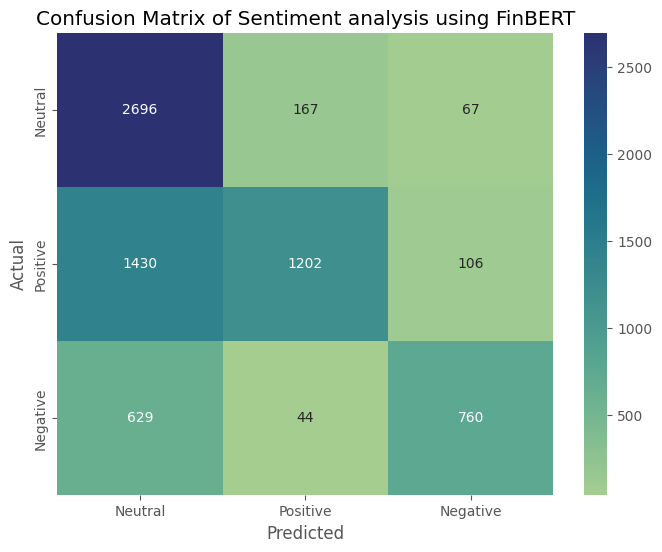

In [ ]:
conf_matrix = confusion_matrix(actual_values, predicted_values)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='crest', xticklabels=['Neutral', 'Positive', 'Negative'], yticklabels=['Neutral', 'Positive', 'Negative'])
plt.title('Confusion Matrix of Sentiment analysis using FinBERT')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()